<a href="https://colab.research.google.com/github/Alton1998/CoronoVirus-Image-Project/blob/main/BIOMED_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomed Project

## Installing Library to work with chest xrays.


In [1]:
!pip -q install torchxrayvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 47.1 MB/s eta 0:00:00


In [54]:
import torchxrayvision as xrv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix

## Downloading covid data set

In [3]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 20.29 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


In [4]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [5]:
MAIN_COVID_DATA_PATH = "covid-chestxray-dataset"
META_DATA_FILE_NAME = "metadata.csv"

In the above data we can see that we have a lot of category of images but for this data set we will focus on Extracting Covid 19 images only

## Reading the metadat provided with this data set.

In [6]:
META_DATA_FILE_PATH = os.path.join(MAIN_COVID_DATA_PATH,META_DATA_FILE_NAME)

In [7]:
meta_data_df = pd.read_csv(META_DATA_FILE_PATH)
FINDINGS_COLUMN = "finding"

In [8]:
meta_data_df[FINDINGS_COLUMN].unique()

array(['Pneumonia/Viral/COVID-19', 'Pneumonia', 'Pneumonia/Viral/SARS',
       'Pneumonia/Fungal/Pneumocystis',
       'Pneumonia/Bacterial/Streptococcus', 'No Finding',
       'Pneumonia/Bacterial/Chlamydophila', 'Pneumonia/Bacterial/E.Coli',
       'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella',
       'Unknown', 'Pneumonia/Lipoid', 'Pneumonia/Viral/Varicella',
       'Pneumonia/Bacterial', 'Pneumonia/Bacterial/Mycoplasma',
       'Pneumonia/Viral/Influenza', 'todo', 'Tuberculosis',
       'Pneumonia/Viral/Influenza/H1N1', 'Pneumonia/Fungal/Aspergillosis',
       'Pneumonia/Viral/Herpes ', 'Pneumonia/Aspiration',
       'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/MERS-CoV',
       'Pneumonia/Bacterial/Staphylococcus/MRSA'], dtype=object)

So the finding we have to target is "Pneumonia/Viral/COVID-19", lets try and find the count for this data

In [9]:
meta_data_df[FINDINGS_COLUMN].value_counts()

Pneumonia/Viral/COVID-19                   584
todo                                        83
Pneumonia                                   81
Pneumonia/Fungal/Pneumocystis               30
Pneumonia/Bacterial/Streptococcus           22
No Finding                                  22
Tuberculosis                                18
Pneumonia/Viral/SARS                        16
Pneumonia/Lipoid                            13
Pneumonia/Bacterial/Mycoplasma              11
Pneumonia/Viral/MERS-CoV                    10
Pneumonia/Bacterial/Klebsiella              10
Pneumonia/Bacterial/Legionella              10
Pneumonia/Bacterial/Nocardia                 8
Pneumonia/Viral/Varicella                    6
Pneumonia/Viral/Influenza                    5
Pneumonia/Bacterial                          4
Pneumonia/Bacterial/E.Coli                   4
Pneumonia/Viral/Herpes                       3
Pneumonia/Bacterial/Chlamydophila            3
Pneumonia/Viral/Influenza/H1N1               2
Pneumonia/Fun

To make life easier lets create an additional column that makes it much easier to understand

In [10]:
meta_data_df["simplified-finding"] = meta_data_df[FINDINGS_COLUMN].apply( lambda x : x.split("/")[-1])

<Axes: title={'center': 'Class Distribution'}>

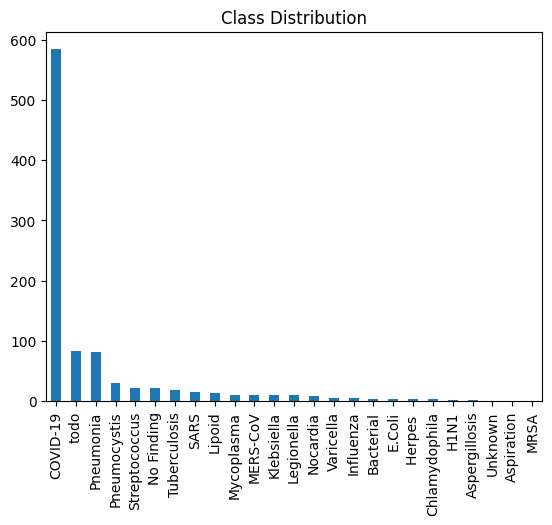

In [11]:
plt.title("Class Distribution")
meta_data_df["simplified-finding"].value_counts().plot(kind="bar")

Lets us see the format these images are in

In [12]:
meta_data_df["file-extension"]=meta_data_df["filename"].apply(lambda x: x.split(".")[-1])

In [13]:
meta_data_df[meta_data_df["simplified-finding"]=="COVID-19"]["file-extension"].value_counts()

jpg     259
png     161
jpeg    139
gz       21
PNG       3
JPG       1
Name: file-extension, dtype: int64

<Axes: title={'center': 'File Extensions used for Covid'}>

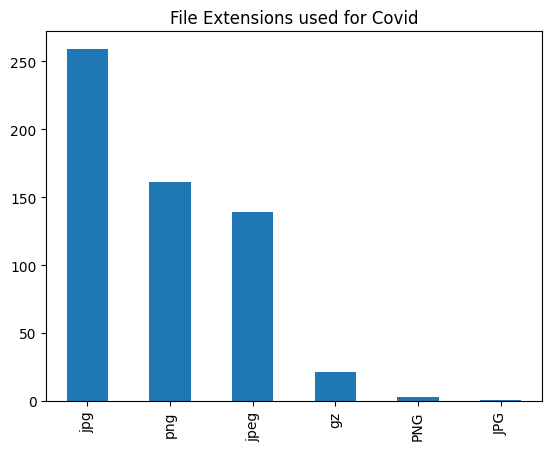

In [14]:
plt.title("File Extensions used for Covid")
meta_data_df[meta_data_df["simplified-finding"]=="COVID-19"]["file-extension"].value_counts().plot(kind="bar")

In [15]:
meta_data_df['view'].unique()

array(['PA', 'AP', 'L', 'Axial', 'AP Supine', 'Coronal', 'AP Erect'],
      dtype=object)

We only care about AP

## Covid DataFrame

In [16]:
covid_df = meta_data_df[(meta_data_df["simplified-finding"]=="COVID-19") & ((meta_data_df["view"]=="AP") | (meta_data_df["view"]=="AP Supine"))]

In [17]:
len(covid_df)

282

In [18]:
covid_df["category"] = covid_df["simplified-finding"]
covid_df["path"] = covid_df["filename"].apply(lambda x : os.path.join("covid-chestxray-dataset","images",x))

In [19]:
covid_df_formatted = covid_df[["category","path"]]

In [20]:
covid_df_formatted

,category,path
34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...
930,COVID-19,covid-chestxray-dataset/images/16953_1_1.jpg
934,COVID-19,covid-chestxray-dataset/images/16892_2_1.png
935,COVID-19,covid-chestxray-dataset/images/16883_1_1.png
937,COVID-19,covid-chestxray-dataset/images/16858_1_1.png


So now we have the covid data we are interested in, we need now  Normal and Bacterial Data

## Installing Kaggle Libraries to Download data from Kaggle

In [21]:
 !pip install -q kaggle

In [22]:
from google.colab import files

## Uploading Creds for use

In [23]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"altondsouza1998","key":"f6daf12cf43403656356348b4c0968c9"}'}

## Creating Kaggle Directory to Store Credentials

In [24]:
 ! mkdir ~/.kaggle

In [25]:
! cp kaggle.json ~/.kaggle/

In [26]:
! chmod 600 ~/.kaggle/kaggle.json

In [27]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 115MB/s] 
100% 2.29G/2.29G [00:28<00:00, 85.9MB/s]


## Unzipping the file so its easy to consume

In [28]:
!unzip  -q chest-xray-pneumonia.zip -d chest-xray-pneumonia

## Traversing chest-xray-pneumonia to get the paths so that we can put that in a data frame and use later

In [29]:
FOLDERS = ["test","train","val"]
categories = []
image_paths = []
for folder in FOLDERS:
  path = os.path.join("chest-xray-pneumonia","chest_xray",folder)
  for currentpath, folders, files in os.walk(path):
      for file in files:
        path = os.path.join(currentpath,file)
        image_paths.append(path)
        category = path.split("/")[3]
        categories.append(category)


In [30]:
chest_xray_df = pd.DataFrame({"category":categories,"path":image_paths})

In [31]:
chest_xray_df["category"].value_counts()

PNEUMONIA    4273
NORMAL       1583
Name: category, dtype: int64

## Combining out Covid and Chest Xrays

In [32]:
final_data = pd.concat([covid_df_formatted,chest_xray_df])

In [33]:
final_data

,category,path
34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...
5851,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5852,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5853,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5854,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...


## Final Distribution

<Axes: ylabel='category'>

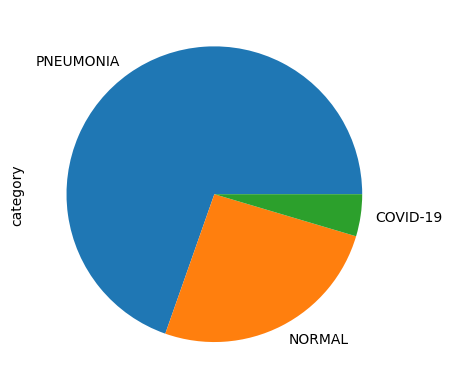

In [34]:
final_data = final_data.reset_index()
final_data["category"].value_counts().plot(kind="pie")

## Performing Transformations

In [35]:
final_data["category"].astype("category")
final_data

,index,category,path
0,34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
1,35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
2,36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
3,40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
4,41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...,...
6133,5851,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6134,5852,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6135,5853,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6136,5854,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...


In [36]:
X=final_data["path"]
y=final_data["category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=101, stratify=y_train, shuffle=True
)

In [37]:
if not os.path.exists("my_data"):
  os.mkdir("my_data")
for folder in FOLDERS:
  path = os.path.join("my_data",folder)
  if not os.path.exists(path):
    os.mkdir(os.path.join("my_data",folder))
  for category in final_data['category'].unique():
    subpath = os.path.join(path,category)
    if not os.path.exists(subpath):
      os.mkdir(subpath)

In [38]:
def data_migrate(dir,X,y):
  i=0
  for path,category in zip(X,y):
    i=i+1
    extension = path.split(".")[-1]
    shutil.copyfile(path, os.path.join("my_data",dir,category,category+"-"+str(i)+"."+extension))


data_migrate("train",X_train,y_train)
data_migrate("test",X_test,y_test)
data_migrate("val",X_val,y_val)

In [39]:
train_transform = transforms.Compose([transforms.Resize(224),
        transforms.CenterCrop(224),transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),transforms.Normalize([0.5],
                             [0.5])])
test_transform = transforms.Compose([transforms.Resize(224),
        transforms.CenterCrop(224),transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),transforms.Normalize([0.5],
                             [0.5])])
val_transform = transforms.Compose([transforms.Resize(224),
        transforms.CenterCrop(224),transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),transforms.Normalize([0.5],
                             [0.5])])

In [40]:
train_data = datasets.ImageFolder(os.path.join("my_data","train"), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join("my_data","test"), transform=test_transform)
val_data = datasets.ImageFolder(os.path.join("my_data","val"), transform=val_transform)

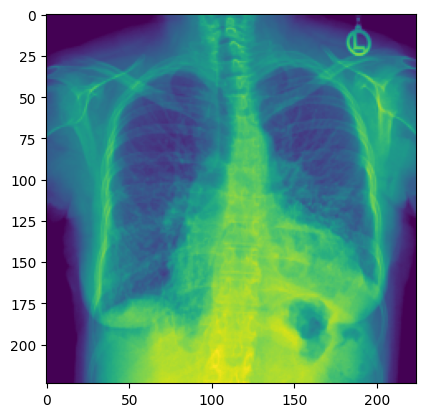

In [41]:
for  i, (data, labels) in enumerate(train_data):
  plt.imshow(data.reshape(224,-1))
  break

## Creating Data loader

In [42]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

Label: [1 1 2 2 2 2 1 2 0 2]
Class: NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA COVID-19 PNEUMONIA


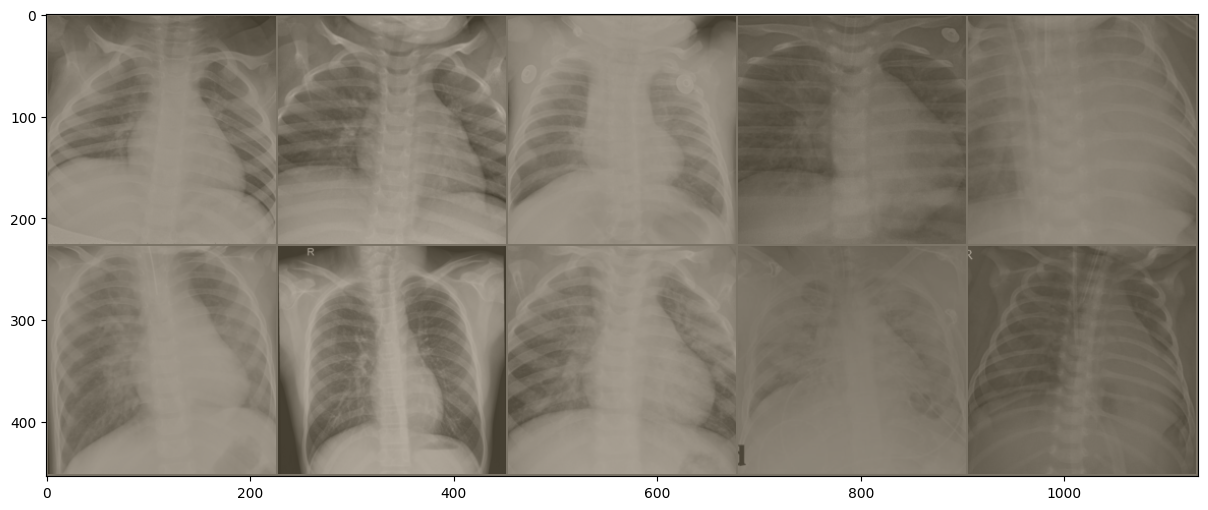

In [43]:
class_names = train_data.classes
# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Creating CNN Model

In [44]:
class CovidCNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    fc_layer_list = []
    conv_layer_list = []

    conv_layer_list.append(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=7,stride=4))
    conv_layer_list.append(nn.ReLU(inplace=True))
    conv_layer_list.append(nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=2))
    conv_layer_list.append(nn.ReLU(inplace=True))
    conv_layer_list.append(nn.MaxPool2d(kernel_size=3,stride=2))
    conv_layer_list.append(nn.BatchNorm2d(32))
    conv_layer_list.append(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1))
    conv_layer_list.append(nn.ReLU(inplace=True))
    conv_layer_list.append(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1))
    conv_layer_list.append(nn.ReLU(inplace=True))
    conv_layer_list.append(nn.MaxPool2d(kernel_size=3,stride=1))
    conv_layer_list.append(nn.BatchNorm2d(128))
    # conv_layer_list.append(nn.Flatten())
    self.conv_layer = nn.Sequential(*conv_layer_list)
    fc_in = 6*6*128

    fc_layer_list.append(nn.Linear(in_features=fc_in,out_features=100))
    fc_layer_list.append(nn.ReLU(inplace=True))
    fc_layer_list.append(nn.Dropout(0.5))
    fc_layer_list.append(nn.Linear(in_features=100,out_features=50))
    fc_layer_list.append(nn.ReLU(inplace= True))
    fc_layer_list.append(nn.Dropout(0.5))
    fc_layer_list.append(nn.Linear(50,3))
    self.fc_layer = nn.Sequential(*fc_layer_list)

  def forward(self,x):
    x = self.conv_layer(x)
    # Flatten doesn't work for some reason
    x = x.reshape(-1,6*6*128)
    x = self.fc_layer(x)
    return x


In [45]:
torch.manual_seed(101)
covid_cnn_model = CovidCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(covid_cnn_model.parameters(),lr=0.001)
covid_cnn_model

CovidCNNModel(
  (conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=4608, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dr

In [46]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [47]:
count_parameters(covid_cnn_model)

     784
      16
   12800
      32
      32
      32
   18432
      64
   73728
     128
     128
     128
  460800
     100
    5000
      50
     150
       3
________
  572407


## Training the CNN Model

In [48]:
import time
start_time = time.time()

epochs = 30

train_accuracies = []
val_accuracies = []
val_mean_losses = []
train_mean_losses = []

tolerance_count = 0

tolerance = 5

for i in range(epochs):
    covid_cnn_model.train()
    trn_corr = 0
    val_corr = 0
    total_train_loss = 0
    total_val_loss = 0


    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        b+=1

        # Apply the model
        y_pred = covid_cnn_model(X_train)
        loss = criterion(y_pred, y_train)
        total_train_loss += loss.item()

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_accuracy = (trn_corr.item() / len(train_data)) * 100
    train_mean_loss = total_train_loss / len(train_data)
    train_accuracies.append(train_accuracy)
    train_mean_losses.append(train_mean_loss)

    # Run the testing batches
    covid_cnn_model.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):

            # Apply the model
            y_test_pred = covid_cnn_model(X_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_test_pred.data, 1)[1]
            val_corr += (predicted == y_val).sum()
            val_loss = criterion(y_test_pred,y_val)
            total_val_loss += val_loss.item()

    val_accuracy = (val_corr.item() / len(val_data)) * 100
    val_mean_loss = total_val_loss / len(val_data)
    val_accuracies.append(val_accuracy)
    val_mean_losses.append(val_mean_loss)

    if val_mean_loss >= train_mean_loss:
      tolerance_count = tolerance_count + 1
    else:
      toleance_count = 0

    if tolerance_count >= tolerance:
      break

    print(f"epoch:{i+1}\tTrain Loss:{train_mean_loss:12.2f}\tTrain Accuracy:{train_accuracy:12.2f}\tVal Loss:{val_mean_loss:12.2f}\tval Accuracy:{val_accuracy:12.2f}\t Tolerance Count:{tolerance_count:12.2f}")

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time

epoch:1	Train Loss:        0.05	Train Accuracy:       80.70	Val Loss:        0.03	val Accuracy:       87.47	 Tolerance Count:        0.00
epoch:2	Train Loss:        0.04	Train Accuracy:       86.81	Val Loss:        0.03	val Accuracy:       90.02	 Tolerance Count:        0.00
epoch:3	Train Loss:        0.03	Train Accuracy:       88.80	Val Loss:        0.03	val Accuracy:       89.92	 Tolerance Count:        0.00
epoch:4	Train Loss:        0.03	Train Accuracy:       89.59	Val Loss:        0.02	val Accuracy:       93.48	 Tolerance Count:        0.00
epoch:5	Train Loss:        0.03	Train Accuracy:       90.89	Val Loss:        0.02	val Accuracy:       91.75	 Tolerance Count:        0.00
epoch:6	Train Loss:        0.03	Train Accuracy:       91.60	Val Loss:        0.02	val Accuracy:       92.06	 Tolerance Count:        0.00
epoch:7	Train Loss:        0.02	Train Accuracy:       92.34	Val Loss:        0.02	val Accuracy:       93.69	 Tolerance Count:        0.00
epoch:8	Train Loss:        0.02	Tr

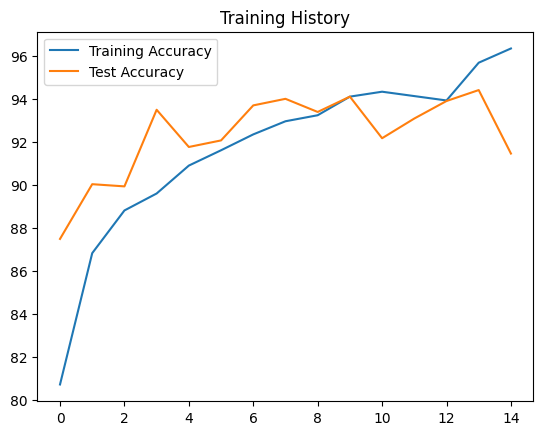

In [49]:
plt.plot(train_accuracies,label="Training Accuracy")
plt.plot(val_accuracies,label="Test Accuracy")
plt.title("Training History")
plt.legend()

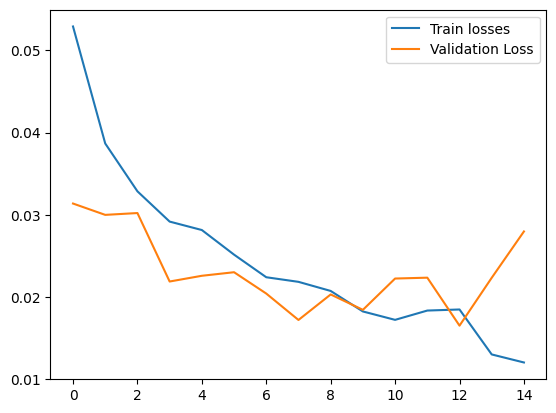

In [50]:
plt.plot(train_mean_losses,label="Train losses")
plt.plot(val_mean_losses,label="Validation Loss")
plt.legend()

Testing the CNN Model

In [51]:
test_corr = 0
total_test_loss = 0
covid_cnn_model.eval()
with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):

    # Apply the model
    y_test_pred = covid_cnn_model(X_test)

    # Tally the number of correct predictions
    predicted = torch.max(y_test_pred.data, 1)[1]
    test_corr += (predicted == y_test).sum()
    test_loss = criterion(y_test_pred,y_test)
    total_test_loss += test_loss.item()
    print(classification_report(predicted,y_test))
    print(confusion_matrix(predicted,y_test))

test_accuracy = (test_corr.item() / len(test_data)) * 100
test_mean_loss = total_test_loss / len(test_data)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        52
           1       0.78      0.98      0.86       252
           2       0.99      0.91      0.95       924

    accuracy                           0.93      1228
   macro avg       0.86      0.92      0.88      1228
weighted avg       0.94      0.93      0.93      1228

[[ 45   2   5]
 [  1 246   5]
 [ 10  69 845]]


In [52]:
print(test_accuracy)

92.50814332247556


In [53]:
test_mean_loss

0.00018633118184459326